In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# 한글 폰트 설치
# https://pinkwink.kr/1255
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import xgboost as xgb
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
import warnings
import shap

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


# Xgboost 선택 이유

- Xgboost는 level_wise_growth, LightGBM은 leaf_wise_growth 방식을 사용합니다.
 - 따라서 Xgboost가 보다 과적합 방지에 용이합니다.
- 이전에 LGBM, RF,ExtraTrees의 결과 비교를 통해서, 이번 대회는 과적합 방지가 가장 큰 키워드라는 것을 알 수 있었습니다.

- 앙상블 모델로 78만점까지 점수를 향상시켰으나, valid set을 제대로 활용하지 못하는 아쉬움이 있었습니다.

- 이러한 아쉬움 때문에, **valid set을 학습에 활용**할 수 있으면서, LGBM에 비해 **소규모 데이터에 용이**하고 **과적합 위험이 적은** Xgboost를 사용해보기로 했습니다.

In [4]:
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/funda_train.csv')
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')
train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')

Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.


Text(0.5, 1, '분기별 매출액의 상관관계')

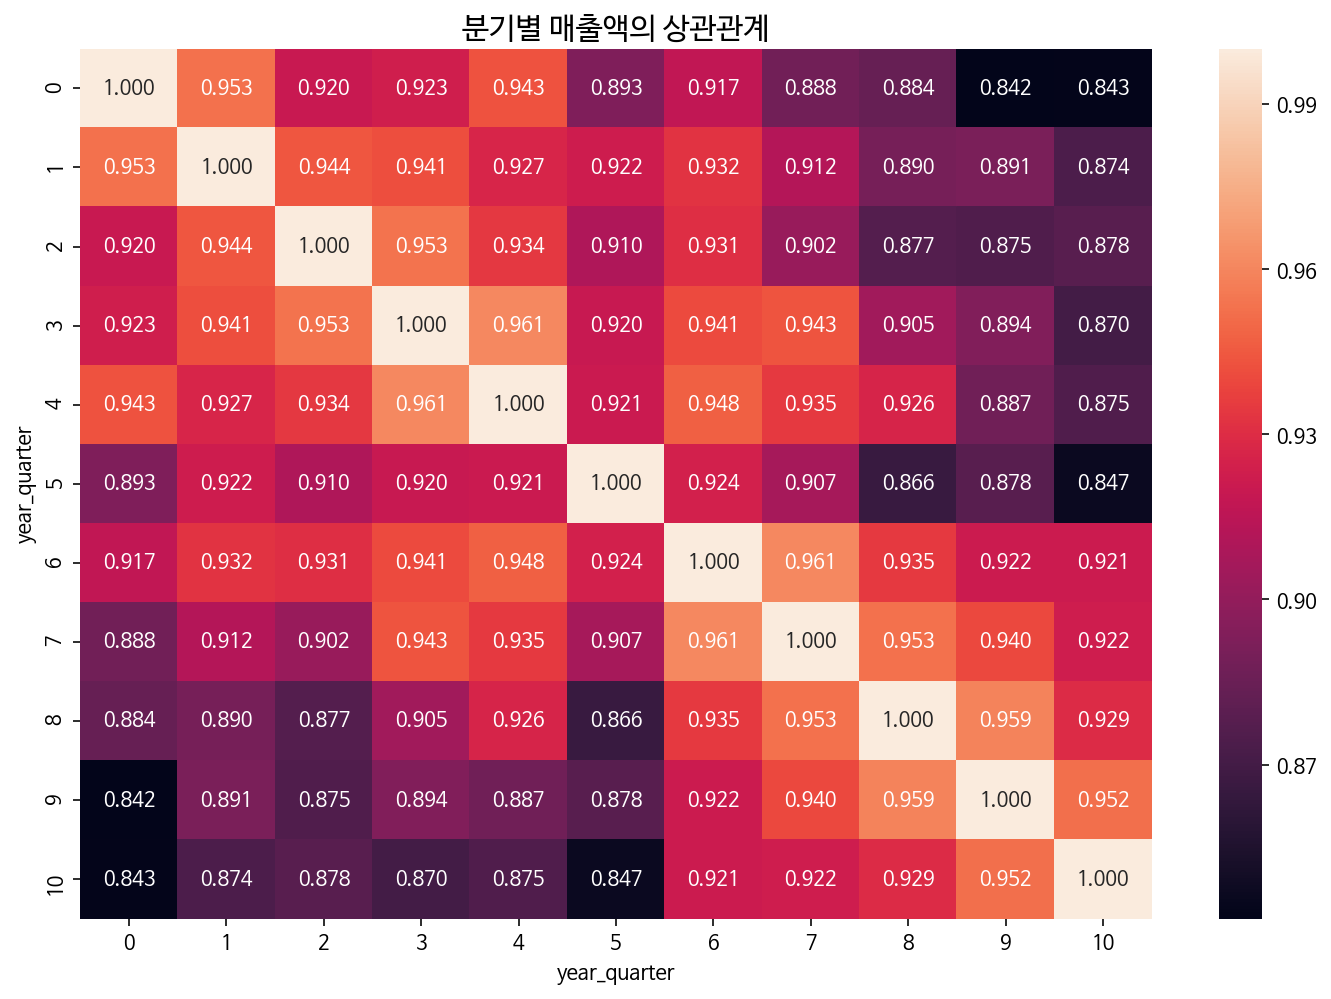

In [9]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.pivot(train3[['store_id','year_quarter','amount']], index='store_id',columns='year_quarter',values='amount').corr(), annot=True,fmt='.3f')
plt.title('분기별 매출액의 상관관계', fontsize=15)

In [0]:
from sklearn.decomposition import PCA
from sklearn import cluster

pca1 = PCA(n_components=15)
X_time = pd.DataFrame(pca1.fit_transform(train3.groupby('store_id').mean().loc[:,'main_h_0':'main_h_23']))
X_time['store_id'] = train3.groupby('store_id').mean().reset_index()['store_id']
k_means = cluster.KMeans(n_clusters=5)
k_means.fit(X_time[X_time.columns[:-1]])
clusters =pd.DataFrame(k_means.labels_, columns=['label'])

time_cluster=pd.concat([X_time,clusters],1)

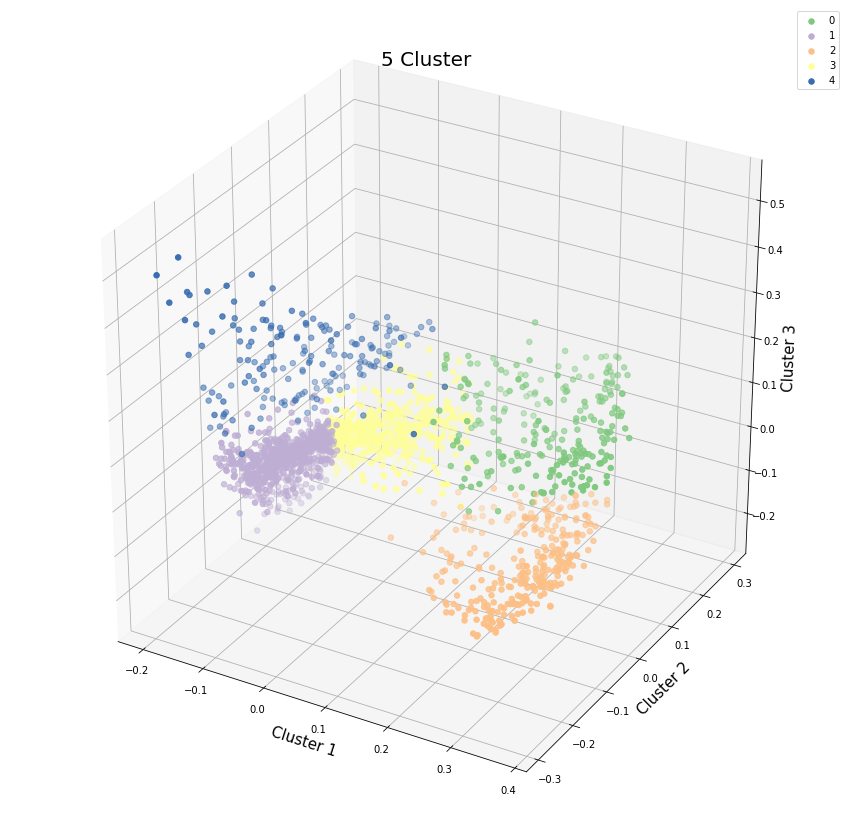

In [0]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
labels = [0,1,2,3,4]
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

ax2.set_xlabel('Cluster 1', fontsize = 15)
ax2.set_ylabel('Cluster 2', fontsize = 15)
ax2.set_zlabel('Cluster 3', fontsize = 15)

ax2.set_title('5 Cluster', fontsize = 20)

colors = ["#7fc97f","#beaed4","#fdc086","#ffff99","#386cb0","#f0027f","","#666666"]
for label, color in zip(labels, colors):
  indicesToKeep = time_cluster['label'] == label
  ax2.scatter(time_cluster.loc[indicesToKeep, 0]
               , time_cluster.loc[indicesToKeep, 1]
               , time_cluster.loc[indicesToKeep, 2]
               
               , c = color
               , s = 30)

ax2.legend(labels)
ax2.grid()

In [0]:
#더미변수
#train3 = pd.merge(train3, time_cluster[['store_id','label']], on='store_id')
#train3 = pd.get_dummies(train3, columns=['label'])
train3 = pd.merge(train3,X_time, on='store_id').drop(list(train3.loc[:,'main_h_0':'main_h_23'].columns), axis=1)
train3 = pd.get_dummies(train3, columns=['region2', 'type_of_business3', 'quarter'])
train3 = train3.drop(['type_of_business', 'region', 'region3'], axis=1)
#train3 = train3.drop(['main_h_3', 'main_h_4', 'main_h_5', 'main_h_6', 'main_h_7', 'main_h_8'], axis=1)

In [0]:
input_var = list(set(train3.columns) - set(['store_id','next_amt','year','region', 'open_0']))
target = 'next_amt'
log_col = []
for col in input_var:
  try:
    if train3[col].mean() > 1000:
      log_col.append(col)
  except:
    pass

In [0]:
for col in log_col:
  train3[col] = np.log1p(train3[col])

invalid value encountered in log1p


In [0]:
# Define train, valid, test
X_test = train3[train3['year_quarter']==10][input_var].drop(error_feature, axis=1)
X_test_id = train3[train3['year_quarter']==10][['store_id']]

X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<8)][input_var].fillna(-9).drop(error_feature, axis=1)

y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<8)][target])
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var].fillna(-9).drop(error_feature, axis=1)
y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target])

X_val_temp = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==8)][input_var].fillna(-9).drop(error_feature, axis=1)
y_val_temp = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==8)][target])

In [0]:
# parameters
xgb_param = {'learning_rate': 0.01, 
          'gamma' : 0.1, # 작으면 과적합
          'min_child_weight' : 1, # 작으면 과적합
          'nthread' : 15,
          'max_depth' : 48,
          'subsample' : 0.5, # 과적합 방지, Tree 생성 전에 train data에서 뽑는 샘플의 비율이다.
          'eval_metric' : 'mae',
          'colsample_bylevel' : 0.8, # 특정 feature의 영향이 큰 경우, 지정해주면 다양한 Tree를 얻을 수 있다. bylevel, bynode도 있음
          'num_boost_round' : 500,
          'n_estimators': 5000,
          'max_leaves': 400,
          'objective': 'reg:squarederror',
          'tree_method': 'exact', # gpu_hist: 데이터가 클 때 효과적이다. hist는 그리디 알고리즘을 대략적으로 계산하기 때문에 성능이 다소 낮기 대문이다.
          #'predictor':'gpu_predictor' 
                   }

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val_temp, label=y_val_temp)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
print("Start!")
model = xgb.train(xgb_param, dtrain, 3000,  watchlist,maximize=False, 
                            early_stopping_rounds = 200, verbose_eval=100)

Series.base is deprecated and will be removed in a future version


Start!
[0]	train-mae:13.9444	valid-mae:13.9459
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:5.10869	valid-mae:5.08984
[200]	train-mae:1.87604	valid-mae:1.85658
[300]	train-mae:0.707519	valid-mae:0.720041
[400]	train-mae:0.291923	valid-mae:0.363623
[500]	train-mae:0.15188	valid-mae:0.277118
[600]	train-mae:0.107442	valid-mae:0.259133
[700]	train-mae:0.090195	valid-mae:0.255024
[800]	train-mae:0.081178	valid-mae:0.254017
[900]	train-mae:0.075858	valid-mae:0.253569
[1000]	train-mae:0.072279	valid-mae:0.253348
[1100]	train-mae:0.069845	valid-mae:0.253254
[1200]	train-mae:0.068088	valid-mae:0.253216
[1300]	train-mae:0.066732	valid-mae:0.25316
[1400]	train-mae:0.065621	valid-mae:0.2531
[1500]	train-mae:0.064732	valid-mae:0.253096
[1600]	train-mae:0.064057	valid-mae:0.253074
[1700]	train-mae:0.063451	valid-mae:0.253035
[1800]	train-mae:0.062958	valid-mae:0.253066
Stopping. Best i

In [0]:
pred1 = model.predict(xgb.DMatrix(X_val_temp))
pred2 = model.predict(xgb.DMatrix(X_valid))
print('year_quarter 8 mae = {}'.format( np.mean(np.abs(np.exp(y_val_temp.values)- np.exp(pred1))) ))
print('year_quarter 9 mae = {}'.format(np.mean(np.abs(np.exp(y_valid.values)- np.exp(pred2)))))

year_quarter 8 mae = 717650.1293985659
year_quarter 9 mae = 710565.3058297065


In [0]:
pred1 = model.predict(xgb.DMatrix(X_val_temp))
pred2 = model.predict(xgb.DMatrix(X_valid))
result_df = pd.DataFrame([['-',0.6,713271,705803 ]],columns=['colsample_bylevel', 'colsample_bynode','year_quarter_8','year_quarter_9'])

In [0]:
a = pd.DataFrame({'colsample_bylevel': [0.8],
                  'colsample_bynode': ['-'],
                  'year_quarter_8': [np.mean(np.abs(np.exp(y_val_temp.values)- np.exp(pred1)))],
                  'year_quarter_9': [np.mean(np.abs(np.exp(y_valid.values)- np.exp(pred2)))]}, index=[1])
result_df = pd.concat([result_df, a], axis=0)

In [0]:
result_df

,colsample_bylevel,colsample_bynode,year_quarter_8,year_quarter_9
0,-,0.6,713271.00000,705803.000000
1,0.8,-,713996.79068,696061.292401


- year_quarter 8,9에서는 과적합 없이 예측이 오히려 더 나아지는데 10에서는 과적합이 심하게 나타남

[<matplotlib.lines.Line2D at 0x7f007ea80630>]

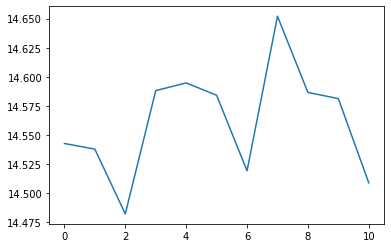

In [0]:
plt.plot(train3.groupby('year_quarter').mean()['amount'])

- 1년 단위로 매출액 추세는 비슷한 추이를 보인다.
- valid set을 1년 전 분기로 해야 하는 것 아닐까?

In [0]:
pred1 = model.predict(xgb.DMatrix(X_val_temp))
pred2 = model.predict(xgb.DMatrix(X_valid))
print('year_quarter 5 mae = {}'.format( np.mean(np.abs(np.exp(y_val_temp.values)- np.exp(pred1))) ))
print('year_quarter 9 mae = {}'.format(np.mean(np.abs(np.exp(y_valid.values)- np.exp(pred2)))))

year_quarter 5 mae = 734087.3636179604
year_quarter 9 mae = 737459.1461091338


- 절대값을 가장 크지만, 점수 차는 가장 작다.

### Error analysis

In [0]:
data_for_ea = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')
quarter9 = data_for_ea[(data_for_ea.next_amt.isna()==False) & (data_for_ea.next_amt>0) &
                 (data_for_ea.year_quarter==9)]
quarter9['real'] = np.exp(y_valid)
quarter9['pred'] = np.exp(pred2)
quarter9['diff'] = quarter9['real'] - quarter9['pred']
quarter9['abs_diff'] = np.abs(quarter9['diff'])

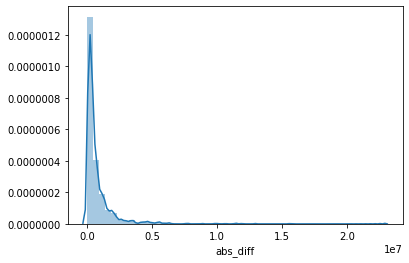

In [0]:
sns.distplot(quarter9['abs_diff'])

In [0]:
pd.concat([quarter9.groupby('type_of_business3').mean()['abs_diff'], quarter9.groupby('type_of_business3').count()['year']], axis=1).sort_values(by='abs_diff',ascending=False)

,abs_diff,year
type_of_business3,,
임대업,6.278222e+06,1
예식장업,5.408633e+06,1
촬영업,2.734590e+06,4
병원,2.721287e+06,1
여행사업,2.509939e+06,2
여관업,2.159302e+06,2
도매업,1.564232e+06,40
판매업,1.094307e+06,14
컨설팅업,1.018132e+06,1


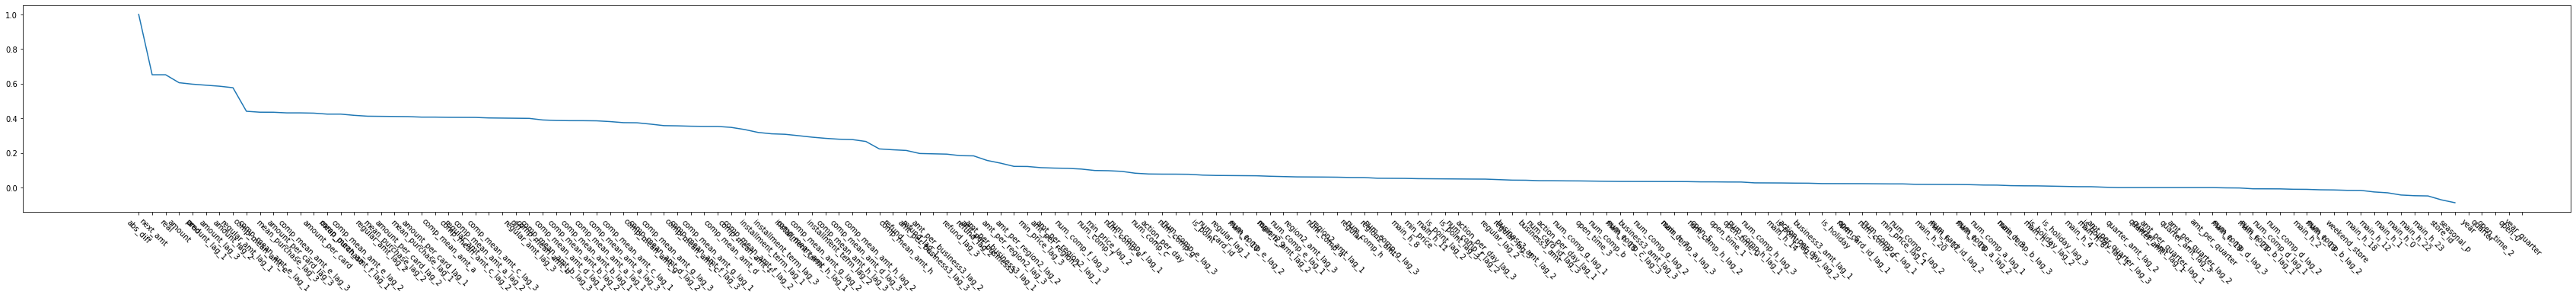

In [0]:
plt.figure(figsize=(60,5))
plt.plot(quarter9.corr()['abs_diff'].sort_values(ascending=False))
plt.xticks(rotation=-45)
plt.show()

In [0]:
error_corr = quarter9.corr()['abs_diff'].reset_index()
error_corr.columns = ['feature','error_corr']
error_corr = pd.merge(error_corr, feature_importances[['feature','average']], on='feature', how='left').sort_values(by='error_corr', ascending=False).reset_index(drop=True)

[<matplotlib.lines.Line2D at 0x7fbdbcd446a0>]

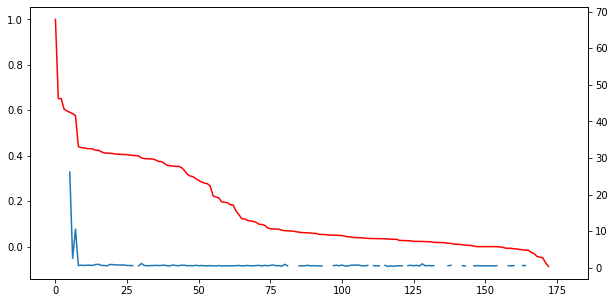

In [0]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(error_corr['error_corr'], color='r')
ax2.plot(error_corr['average'])

In [0]:
error_feature = list(error_corr[(error_corr.average<=0.6) & (error_corr.error_corr>=0.2)].feature)
error_feature

['regular_amt_lag_1',
 'regular_amt_lag_2',
 'comp_mean_amt_a_lag_2',
 'comp_mean_amt_c_lag_3',
 'regular_amt_lag_3',
 'comp_mean_amt_d_lag_1',
 'comp_mean_amt_b_lag_2',
 'comp_mean_amt_b_lag_1',
 'comp_mean_amt_a_lag_3',
 'comp_mean_amt_d_lag_2',
 'comp_mean_amt_g_lag_3',
 'comp_mean_amt_f_lag_3',
 'comp_mean_amt_g_lag_1',
 'comp_mean_amt_f_lag_2',
 'installment_term_lag_1',
 'installment_term_lag_3',
 'comp_mean_amt_h_lag_1',
 'comp_mean_amt_g_lag_2',
 'installment_term_lag_2',
 'comp_mean_amt_h_lag_3',
 'comp_mean_amt_d_lag_3',
 'comp_mean_amt_h_lag_2',
 'refund',
 'comp_mean_amt_h']

In [0]:
error_feature = ['regular_amt_lag_1', 'regular_amt_lag_2', 'comp_mean_amt_a_lag_2', 'comp_mean_amt_c_lag_3', 'regular_amt_lag_3', 'comp_mean_amt_d_lag_1', 'comp_mean_amt_b_lag_2', 'comp_mean_amt_b_lag_1', 'comp_mean_amt_a_lag_3', 'comp_mean_amt_d_lag_2', 'comp_mean_amt_g_lag_3', 'comp_mean_amt_f_lag_3', 'comp_mean_amt_g_lag_1', 'comp_mean_amt_f_lag_2', 'installment_term_lag_1', 'installment_term_lag_3', 'comp_mean_amt_h_lag_1', 'comp_mean_amt_g_lag_2', 'installment_term_lag_2', 'comp_mean_amt_h_lag_3', 'comp_mean_amt_d_lag_3', 'comp_mean_amt_h_lag_2', 'refund', 'comp_mean_amt_h']

- 오차와의 상관관계가 높으면서 모델에서 중요도가 낮는 변수를 제거

# Bayesian Opt

In [0]:
!pip install  Bayesian-Optimization

  Created wheel for Bayesian-Optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=848dc738e5fd26025f7a5d4ec0b6d5a535370caef2ce5e0b4c96d237993c87b3
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built Bayesian-Optimization


In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold


def XGB_bayesian(
    #learning_rate,
    gamma,
    min_child_weight,
    #colsample_bytree,
    #subsample,
    max_depth,
   # num_leaves, 
    reg_alpha,
    reg_lambda,
     ):
    
    # Xgboost expects next two parameters need to be integer. 
    
    #num_leaves = int(num_leaves)
    max_depth = int(max_depth)

    #assert type(max_leaves) == int
    assert type(max_depth) == int
    

    param = {
        'learning_rate': 0.001, 
          'gamma' : gamma, # 작으면 과적합
          'min_child_weight' : min_child_weight, # 작으면 과적합
          'colsample_bynode' : 0.8, # 특정 feature의 영향이 큰 경우, 지정해주면 다양한 Tree를 얻을 수 있다. bylevel, bynode도 있음
          'subsample' : 0.5, # 과적합 방지, Tree 생성 전에 train data에서 뽑는 샘플의 비율이다.
          'max_depth' : int(round(max_depth)),
          #'max_leaves': int(round(max_leaves)),
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda,
          'eval_metric' : 'mae',
         # 'num_boost_round' : 500,
          'n_estimators': 50000,
          'nthread' : 15,
          'objective': 'reg:squarederror',
         'tree_method': 'gpu_hist', # gpu_hist: 데이터가 클 때 효과적이다. hist는 그리디 알고리즘을 대략적으로 계산하기 때문에 성능이 다소 낮기 대문이다.
                                    # 하지만 이번에는 시간 단축을 위해 gpu_hist를 사용하고자 한다. 실제 예측에서는 exact를 사용할 것이다. 
         'predictor':'gpu_predictor'
         }   
    # k-fold
    cv_results = []          
#    n_splits = 10
#    split = StratifiedKFold(n_splits=n_splits, shuffle=False ,random_state=42)
#    split.get_n_splits(X_valid, y_valid)
#    for train_index, test_index in split.split(X_valid, y_valid): # 
#      X1_valid, X2_valid = X_valid.iloc[train_index], X_valid.iloc[test_index]
#      y1_valid, y2_valid = y_valid[train_index], y_valid[test_index]
#      X2_train = pd.concat([X_train, X1_valid], axis=0)
#      y2_train = pd.concat([y_train, y1_valid], axis=0)      
#      dtrain = xgb.DMatrix(X2_train, label=y2_train)
#      dvalid = xgb.DMatrix(X2_valid, label=y2_valid)
    
    # leave_one_out
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)  
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    cv_result = xgb.train(param, dtrain, 50000,  watchlist, maximize=False, 
                            early_stopping_rounds = 200, verbose_eval=500)
      
    cv_results.append(cv_result.best_score)   

    return np.mean(cv_results)*(-1)

In [0]:
# Bounded region of parameter space
bounds_XGB = {
    #'learning_rate': 0.01, 
    'gamma' : (0.1, 5), # 작으면 과적합
    'min_child_weight' : (1,5), # 작으면 과적합
    #'colsample_bytree' : 0.8, # 특정 feature의 영향이 큰 경우, 지정해주면 다양한 Tree를 얻을 수 있다. bylevel, bynode도 있음
    #'subsample' : 0.5, # 과적합 방지, Tree 생성 전에 train data에서 뽑는 샘플의 비율이다.
    'max_depth' : (3,10),
    #'max_leaves': (),
    'reg_alpha': (1,3),
    'reg_lambda': (0.000001,2)
}

In [0]:
import warnings
# 베이지안 opt
XGB_BO = BayesianOptimization(XGB_bayesian, bounds_XGB, random_state=42)

init_points = 10
n_iter = 30

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
[0]	train-mae:14.0712	valid-mae:14.0034
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[500]	train-mae:8.53523	valid-mae:8.46157
[1000]	train-mae:5.17814	valid-mae:5.10292
[1500]	train-mae:3.14421	valid-mae:3.07679
[2000]	train-mae:1.91617	valid-mae:1.86247
[2500]	train-mae:1.17742	valid-mae:1.14173
[3000]	train-mae:0.736203	valid-mae:0.724303
[3500]	train-mae:0.478595	valid-mae:0.490561
[4000]	train-mae:0.33742	valid-mae:0.366314
[4500]	train-mae:0.265489	valid-mae:0.307782
[5000]	train-mae:0.230785	valid-mae:0.280597
[5500]	train-mae:0.213777	valid-mae:0.268736
[6000]	train-mae:0.204345	vali

KeyboardInterrupt: ignored

In [0]:
XGB_BO.max

{'params': {'gamma': 0.200864022049432,
  'max_depth': 9.78936896513396,
  'min_child_weight': 4.329770563201687,
  'reg_alpha': 1.4246782213565523,
  'reg_lambda': 0.363650752589234},
 'target': -0.257385}

# Test

In [0]:
# Define train, valid, test
X_test = train3[train3['year_quarter']==10][input_var].drop(error_feature, axis=1)
X_test_id = train3[train3['year_quarter']==10][['store_id']]

X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 ((train3.year_quarter<9) & (train3.year_quarter!=6))][input_var].fillna(-9).drop(error_feature, axis=1)

y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 ((train3.year_quarter<9) & (train3.year_quarter!=6))][target])

X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var].fillna(-9).drop(error_feature, axis=1)
y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target])

In [0]:
xgb_param = {'learning_rate': 0.005, 
          'gamma' : 0.200864022049432, # 작으면 과적합
          'min_child_weight' : 4.329770563201687, # 작으면 과적합
          'max_depth' : 10,
          'subsample' : 0.5, # 과적합 방지, Tree 생성 전에 train data에서 뽑는 샘플의 비율이다.
          'eval_metric' : 'mae',
          'colsample_bylevel' : 0.8, # 특정 feature의 영향이 큰 경우, 지정해주면 다양한 Tree를 얻을 수 있다. bylevel, bynode도 있음
          'n_estimators': 50000,
          'objective': 'reg:squarederror',
          'reg_alpha': 1.4246782213565523,
          'reg_lambda': 0.363650752589234,
          'tree_method': 'exact', # gpu_hist: 데이터가 클 때 효과적이다. hist는 그리디 알고리즘을 대략적으로 계산하기 때문에 성능이 다소 낮기 대문이다.
          #'predictor':'gpu_predictor' 
                   }

In [0]:
from time import time
import datetime
from sklearn.model_selection import KFold, GroupKFold

CV= []
iteration=[]
evals_result = {}
evals_results = []
X_test_id['amount'] = 0
n_splits = 5
folds = KFold(n_splits=n_splits)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
training_start_time = time()


for fold, (trn_idx, test_idx) in enumerate(folds.split(X_valid, y_valid)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    # valid를 kfold 내에서 검증용과 훈련용으로 나눔
    X1_valid, X2_valid = X_valid.iloc[trn_idx], X_valid.iloc[test_idx]
    y1_valid, y2_valid = y_valid.iloc[trn_idx], y_valid.iloc[test_idx]
    # X1_valid는 훈련용으로 다시 합침
    X2_train = pd.concat([X_train, X1_valid], axis=0)
    y2_train = pd.concat([y_train, y1_valid], axis=0)

    trn_data = xgb.DMatrix(X2_train, label=y2_train)
    val_data = xgb.DMatrix(X2_valid, label=y2_valid)
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    model = xgb.train(xgb_param, trn_data, 50000,  watchlist,maximize=False, 
                            early_stopping_rounds = 200, verbose_eval=1000)
    
    CV.append(model.best_score)
# Predict
    X_test_id['amount'] += model.predict(xgb.DMatrix(X_test))
    #feature_importances['fold_{}'.format(fold + 1)] = model.get_score(importance_type='gain')
    fe = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient='index').reset_index()
    fe.columns = ['feature', 'fold_{}'.format(fold + 1)]
    feature_importances = pd.merge(feature_importances, fe, on='feature')

X_test_id['amount'] = np.exp(X_test_id['amount'] / n_splits) 

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))
print('-' * 30)

Training on fold 1


Series.base is deprecated and will be removed in a future version


[0]	train-mae:14.0036	valid-mae:13.7991
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:0.248163	valid-mae:0.277848
Stopping. Best iteration:
[1464]	train-mae:0.199898	valid-mae:0.258635

Training on fold 2
[0]	train-mae:14.0014	valid-mae:13.89
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:0.247103	valid-mae:0.300444
[2000]	train-mae:0.170215	valid-mae:0.277131
[3000]	train-mae:0.140429	valid-mae:0.276234
Stopping. Best iteration:
[2870]	train-mae:0.143016	valid-mae:0.276107

Training on fold 3
[0]	train-mae:13.9964	valid-mae:14.0902
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:0.247774	valid-mae:0.275376
[2000]	train-mae:0.172005	valid-mae:0.25336

In [0]:
0.2436006

In [0]:
Training on fold 1
[0]	train-mae:14.0685	valid-mae:13.8548
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
Series.base is deprecated and will be removed in a future version
[1000]	train-mae:5.1761	valid-mae:5.03967
[2000]	train-mae:1.91336	valid-mae:1.82813
[3000]	train-mae:0.734841	valid-mae:0.705682
[4000]	train-mae:0.335161	valid-mae:0.361418
[5000]	train-mae:0.224826	valid-mae:0.277515
[6000]	train-mae:0.196251	valid-mae:0.261395
[7000]	train-mae:0.18436	valid-mae:0.257878
[8000]	train-mae:0.175522	valid-mae:0.257179
[9000]	train-mae:0.167597	valid-mae:0.256958
Stopping. Best iteration:
[9359]	train-mae:0.164906	valid-mae:0.256827

Training on fold 2
[0]	train-mae:14.0665	valid-mae:13.9462
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:5.17552	valid-mae:5.0713
[2000]	train-mae:1.91271	valid-mae:1.85851
[3000]	train-mae:0.734164	valid-mae:0.740686
[4000]	train-mae:0.334694	valid-mae:0.390271
[5000]	train-mae:0.22362	valid-mae:0.305312
[6000]	train-mae:0.194288	valid-mae:0.286355
[7000]	train-mae:0.181837	valid-mae:0.281998
[8000]	train-mae:0.172705	valid-mae:0.280685
[9000]	train-mae:0.1645	valid-mae:0.280261
[9999]	train-mae:0.157035	valid-mae:0.27987
Training on fold 3
[0]	train-mae:14.0621	valid-mae:14.147
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:5.17386	valid-mae:5.16304
[2000]	train-mae:1.91255	valid-mae:1.88694
[3000]	train-mae:0.73448	valid-mae:0.73786
[4000]	train-mae:0.335035	valid-mae:0.374745
[5000]	train-mae:0.224737	valid-mae:0.283242
[6000]	train-mae:0.195976	valid-mae:0.263098
[7000]	train-mae:0.184042	valid-mae:0.258483
[8000]	train-mae:0.175186	valid-mae:0.256557
[9000]	train-mae:0.167272	valid-mae:0.255644
[9999]	train-mae:0.160038	valid-mae:0.254906
Training on fold 4
[0]	train-mae:14.0646	valid-mae:14.0355
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:5.17497	valid-mae:5.10701
[2000]	train-mae:1.91301	valid-mae:1.85134
[3000]	train-mae:0.734654	valid-mae:0.710622
[4000]	train-mae:0.335462	valid-mae:0.354131
[5000]	train-mae:0.225214	valid-mae:0.265233
[6000]	train-mae:0.19643	valid-mae:0.247801
[7000]	train-mae:0.184448	valid-mae:0.243685
[8000]	train-mae:0.175597	valid-mae:0.242135
[9000]	train-mae:0.167684	valid-mae:0.241773
[9999]	train-mae:0.160319	valid-mae:0.241351
Training on fold 5
[0]	train-mae:14.0646	valid-mae:14.0335
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[1000]	train-mae:5.17495	valid-mae:5.13237
[2000]	train-mae:1.91286	valid-mae:1.88463
[3000]	train-mae:0.734543	valid-mae:0.750897
[4000]	train-mae:0.33512	valid-mae:0.379104
[5000]	train-mae:0.22463	valid-mae:0.286775
[6000]	train-mae:0.196028	valid-mae:0.264288
[7000]	train-mae:0.184035	valid-mae:0.258392
[8000]	train-mae:0.175248	valid-mae:0.256398
[9000]	train-mae:0.16734	valid-mae:0.255586
[9999]	train-mae:0.160043	valid-mae:0.255188
------------------------------
Training has finished.
Total training time is 0:13:24.407212
CV mean 0.2576128, CV std 0.01244680366037802

Glyph 51116 missing from current font.
Glyph 48176 missing from current font.
Glyph 50629 missing from current font.
Glyph 46020 missing from current font.
Glyph 47588 missing from current font.
Glyph 44277 missing from current font.
Glyph 49324 missing from current font.
Glyph 51228 missing from current font.
Glyph 51452 missing from current font.
Glyph 49436 missing from current font.
Glyph 50872 missing from current font.
Glyph 44305 missing from current font.
Glyph 51020 missing from current font.
Glyph 47308 missing from current font.
Glyph 51216 missing from current font.
Glyph 50868 missing from current font.
Glyph 50689 missing from current font.
Glyph 51116 missing from current font.
Glyph 48176 missing from current font.
Glyph 50629 missing from current font.
Glyph 46020 missing from current font.
Glyph 47588 missing from current font.
Glyph 44277 missing from current font.
Glyph 49324 missing from current font.
Glyph 51228 missing from current font.
Glyph 51452 missing from 

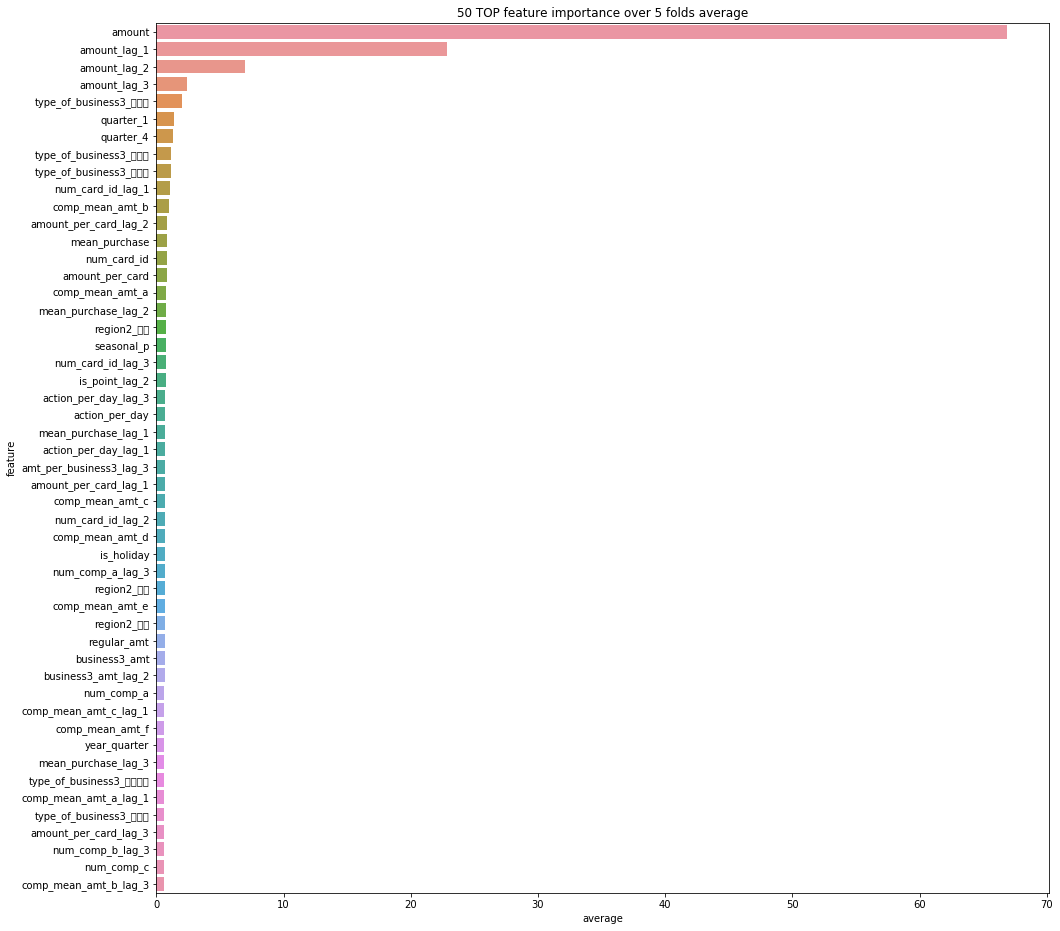

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
train4 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')

# 19년 1분기에 매출이 없는 가게들은 과거 같은 분기 매출액으로 대체
rest_store = list(set(train.store_id.unique()) - set(X_test_id.store_id.unique())) # 19년 1분기 매출이 없는 가게
rest_2018_1 = train4.loc[(train4['store_id'].isin(rest_store)) & (train4['quarter']==2) & (train4['year']==2018)][['store_id','amount']] # 18년 2분기로 대체

rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train4.loc[(train4['store_id'].isin(rest_list1)) & (train4['quarter']==2) & (train4['year']==2017)][['store_id','amount']] # 17년 2분기로 대체

rest_list2 = set(rest_list1) - set(rest_2018_2.store_id.unique())
rest_2018_3 = train4.loc[(train4['store_id'].isin(rest_list2))][['store_id','amount']] # 17년 2분기로 대체
rest_2018_3 = rest_2018_3.groupby('store_id').mean().reset_index()

reset_st = pd.concat([rest_2018_1, rest_2018_2,rest_2018_3], axis=0)

Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.


In [0]:
X_test_id = pd.concat([X_test_id, reset_st], axis=0) # 예측값 병합
submission2 = pd.merge(submission.drop('amount',axis=1),X_test_id, on='store_id')

In [0]:
submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/XGB_submission_5fold_del_fe.csv',index=False)

In [0]:
# 5-fold, bylevel=0.8, 시간 변수 15개로 pca
#submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/XGB_submission_5fold_2.csv',index=False)
# valid = 0.2576(70만 초반)
# test = 820,000

In [0]:
submission2

,store_id,amount
0,0,2.197046e+06
1,1,3.402996e+05
2,2,1.343914e+06
3,4,2.651329e+06
4,5,1.126878e+06
...,...,...
1962,2132,1.895013e+06
1963,2133,1.418629e+06
1964,2134,5.167531e+05
1965,2135,1.575575e+06


In [0]:
1898+69

1967